In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from bertopic import BERTopic
import seaborn as sns

/Users/dominik/venv/bertopic/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
sentences = ["This is an example sentence", "Each sentence is converted"]
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2", output_hidden_states=True)
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

In [3]:
def cls_pooling(hidden_states, layer_number):
    return hidden_states[layer_number][:, 0, :]

def mean_pooling(hidden_states, layer_number, attention_mask):
    token_embeddings = hidden_states[
        layer_number
    ]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

def max_pooling(hidden_states, layer_number, attention_mask):
    token_embeddings = hidden_states[layer_number]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
    max_embeddings = torch.max(token_embeddings, 1)[0]
    return max_embeddings

In [4]:
def get_embedding_from_layer(
    model_output,
    layer_number,
    attention_mask=None,
    pooling="cls",
):
    hidden_states = model_output["hidden_states"]
    
    if pooling == "cls":
        return cls_pooling(hidden_states, layer_number)
    
    elif pooling == "mean":
        assert attention_mask != None, "Please provide attention mask if you are using mean pooling"
        return mean_pooling(hidden_states, layer_number, attention_mask)
    
    elif pooling == "max":
        assert attention_mask != None, "Please provide attention mask if you are using max pooling"
        return max_pooling(hidden_states, layer_number, attention_mask)
    
    else:
        raise ValueError("Wrong pooling method provided in the function call")
        

In [5]:
def get_embedding_layer_output(model_output, attention_mask=None, pooling="cls"):
    return get_embedding_from_layer(model_output, 0, attention_mask, pooling).numpy()


def get_last_hidden_layer_output(model_output, attention_mask=None, pooling="cls"):
    return get_embedding_from_layer(model_output, -1, attention_mask, pooling).numpy()


def get_sum_all_layers(model_output, attention_mask=None, pooling="cls"):
    outputs = []
    for l in range(np.shape(model_output["hidden_states"])[0]):
        output = get_embedding_from_layer(model_output, l, attention_mask, pooling)
        outputs.append(output.numpy())
    return sum(outputs)


def get_second_last_layer_output(model_output, attention_mask=None, pooling="cls"):
    return get_embedding_from_layer(model_output, -2, attention_mask, pooling).numpy()


def get_sum_last_four_layers(model_output, attention_mask=None, pooling="cls"):
    outputs = []
    layers = [-4, -3, -2, -1]
    for layer in layers:
        output = get_embedding_from_layer(model_output, layer, attention_mask, pooling)
        outputs.append(output.numpy())
    return sum(outputs)


def get_concat_last_four_layers(model_output, attention_mask=None, pooling="cls"):
    outputs = []
    layers = [-4, -3, -2, -1]
    for layer in layers:
        output = get_embedding_from_layer(model_output, layer, attention_mask, pooling)
        outputs.append(output)
    return torch.cat(outputs, dim=-1).numpy()


In [6]:
functions = [get_embedding_layer_output, get_last_hidden_layer_output, get_second_last_layer_output, get_sum_all_layers, get_sum_last_four_layers, get_concat_last_four_layers]

Think about normalizing embedding

In [7]:
np.min(model_output.last_hidden_state[:, 0, :].numpy())

NameError: name 'model_output' is not defined

In [ ]:
np.max(model_output.last_hidden_state[:, 0, :].numpy())

3.3641794

In [8]:
tweets = pd.read_csv("../data/tweets.csv")

In [9]:
texts = tweets["text"][:100].tolist()

In [10]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2", output_hidden_states=True)
encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
attention_mask = encoded_input["attention_mask"]

with torch.no_grad():
    model_output = model(**encoded_input)

In [20]:
methods_dict = {}
poolings = ["cls", "mean", "max"]
for f in functions:
    for p in poolings:
        print(f.__name__, p)
        embeddings = f(model_output = model_output, attention_mask = attention_mask, pooling=p)
        key_name = f.__name__ + "_" + p
        methods_dict[key_name] = {}
        methods_dict[key_name]["embeddings"] = embeddings

get_embedding_layer_output cls
get_embedding_layer_output mean
get_embedding_layer_output max
get_last_hidden_layer_output cls
get_last_hidden_layer_output mean
get_last_hidden_layer_output max
get_second_last_layer_output cls
get_second_last_layer_output mean
get_second_last_layer_output max
get_sum_all_layers cls
get_sum_all_layers mean
get_sum_all_layers max
get_sum_last_four_layers cls
get_sum_last_four_layers mean
get_sum_last_four_layers max
get_concat_last_four_layers cls
get_concat_last_four_layers mean
get_concat_last_four_layers max


In [24]:
topic_model = BERTopic()
for key in methods_dict:
    topics, probs = topic_model.fit_transform(texts, methods_dict[key]["embeddings"])
    methods_dict[key]["topics"] = topics
    methods_dict[key]["probs"] = probs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:
methods_dict[0]

KeyError: 0

In [33]:
methods_dict["get_embedding_layer_output_cls"]["probs"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

get_embedding_layer_output_cls
get_embedding_layer_output_mean
get_embedding_layer_output_max
get_last_hidden_layer_output_cls
get_last_hidden_layer_output_mean
get_last_hidden_layer_output_max
get_second_last_layer_output_cls
get_second_last_layer_output_mean
get_second_last_layer_output_max
get_sum_all_layers_cls
get_sum_all_layers_mean
get_sum_all_layers_max
get_sum_last_four_layers_cls
get_sum_last_four_layers_mean
get_sum_last_four_layers_max
get_concat_last_four_layers_cls
get_concat_last_four_layers_mean
get_concat_last_four_layers_max


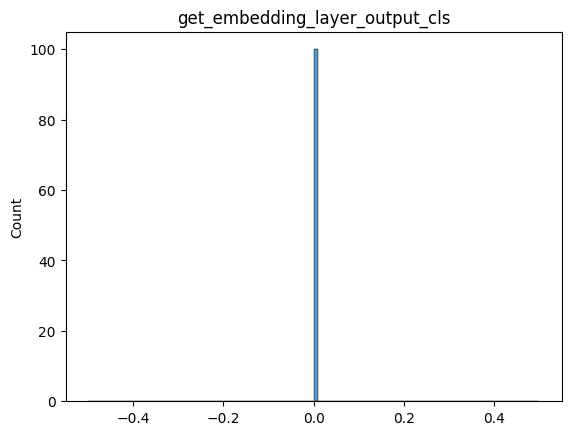

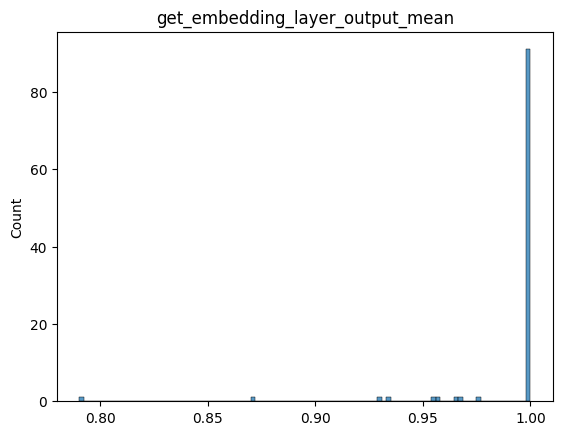

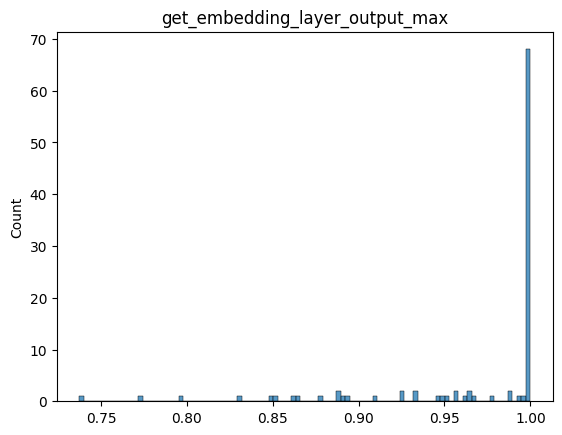

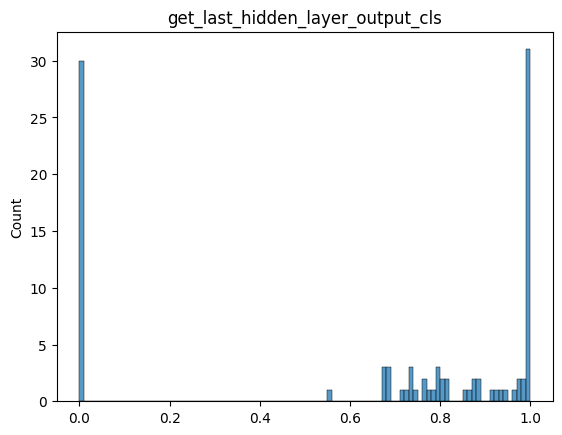

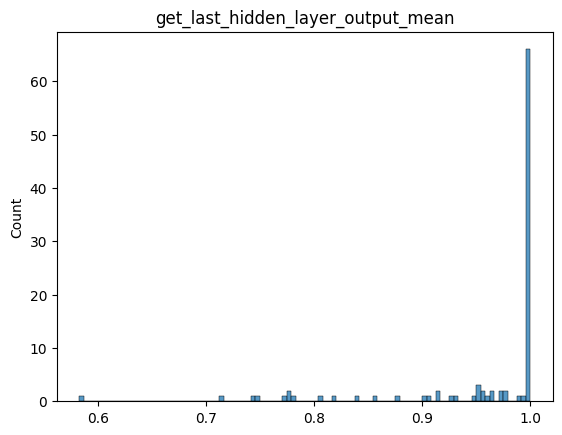

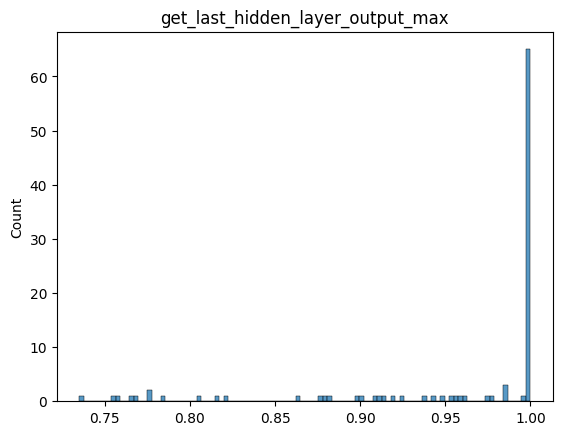

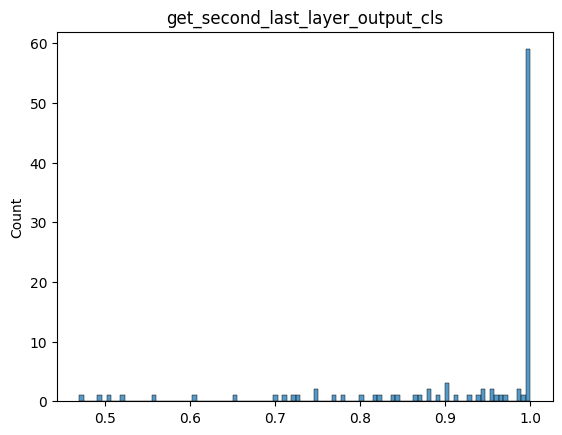

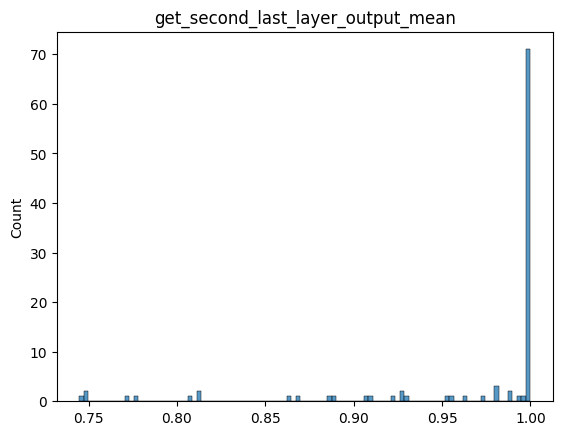

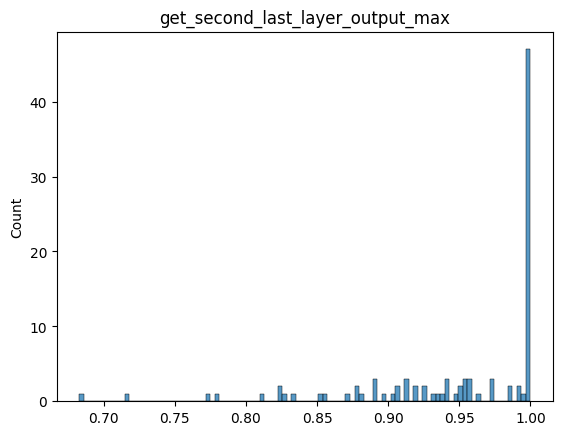

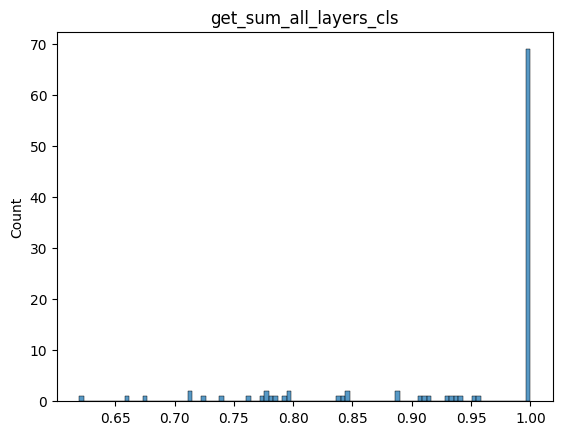

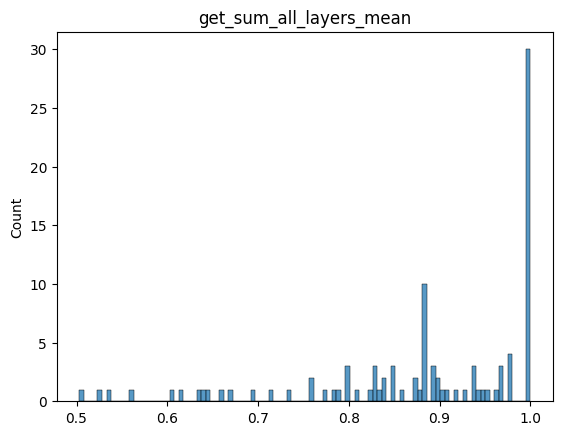

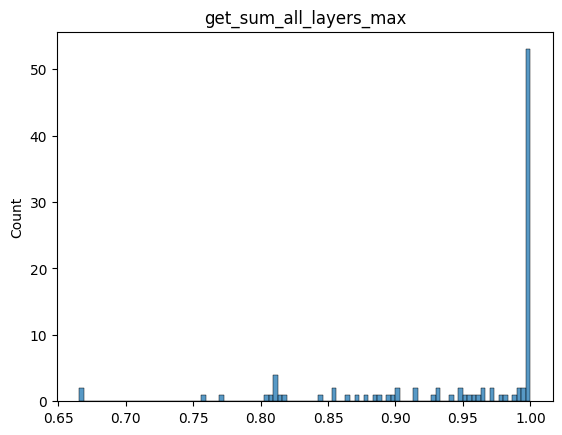

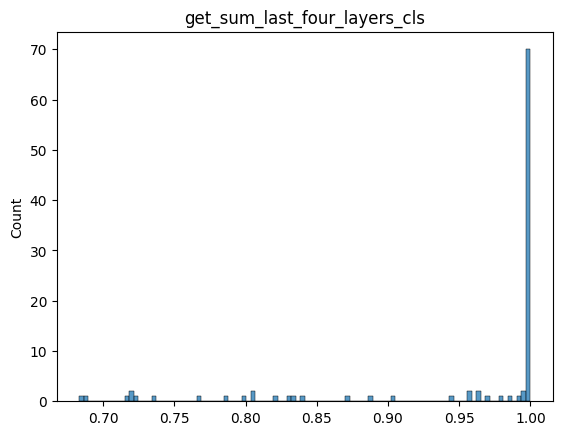

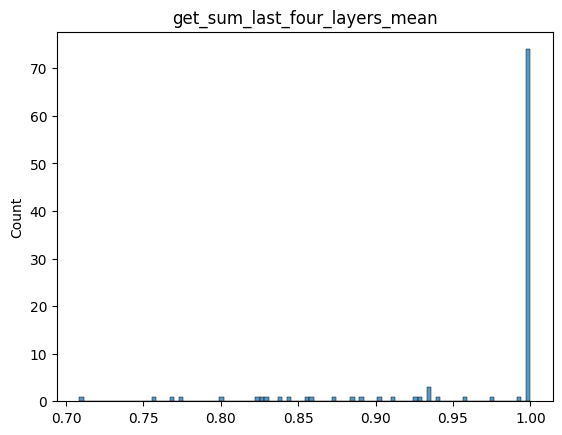

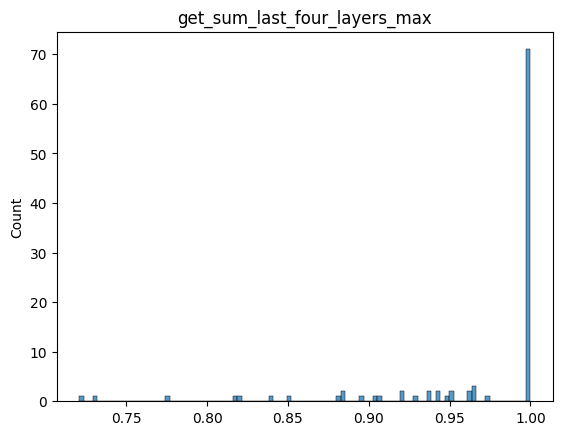

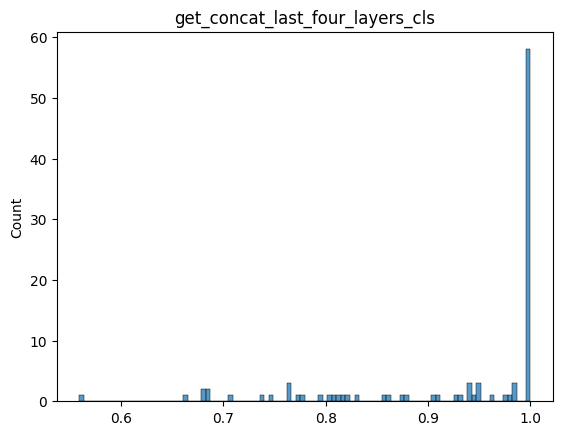

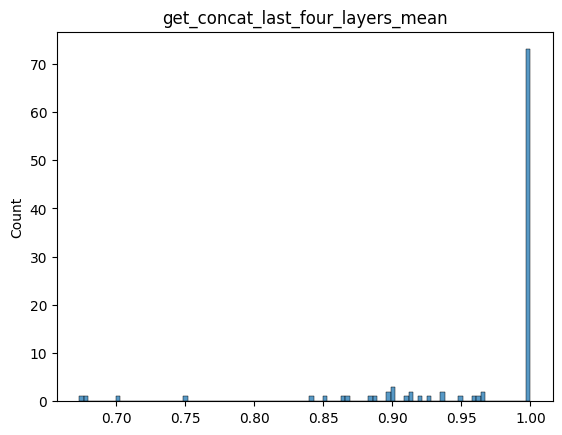

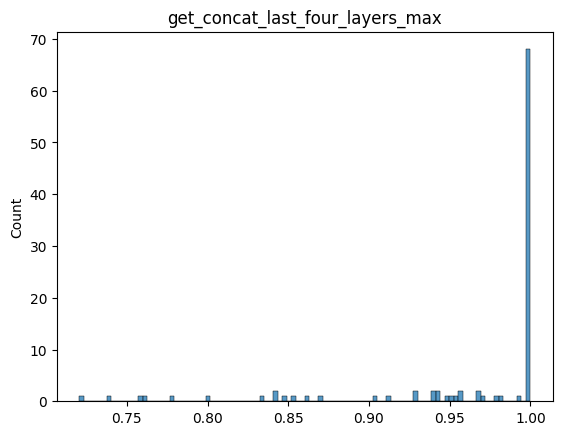

In [40]:
import matplotlib.pyplot as plt
num_plots = 18
plots = []

for i, k in enumerate(methods_dict):
    print(k)
    plt.figure()
    p = sns.histplot(methods_dict[k]["probs"], bins=100).set(title=k)
